# Initialization

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, Adam, Nadam, AdamW
from tensorflow.keras.optimizers import Optimizer
from tensorflow.keras.models import save_model
import time
import matplotlib.pyplot as plt

In [ ]:
!nvidia-smi

Sat May 10 20:56:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import json
import pickle

def save_all_results(name, history, model, training_time, test_accuracy, save_dir='/content/drive/MyDrive/vgg_results'):
    os.makedirs(save_dir, exist_ok=True)

    with open(os.path.join(save_dir, f'{name}_history.json'), 'w') as f:
        json.dump(history.history, f)

    model.save(os.path.join(save_dir, f'{name}_model.h5'))

    summary = {
        'training_time': training_time,
        'test_accuracy': test_accuracy
    }
    with open(os.path.join(save_dir, f'{name}_summary.json'), 'w') as f:
        json.dump(summary, f)

# Data Preprocessing

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)  # One-hot encoding

# Split training data into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Resize images to (224, 224)
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.vgg16.preprocess_input(image)
    return image, label

batch_size = 32
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(preprocess).shuffle(1000).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).map(preprocess).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(preprocess).batch(batch_size)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


# Build Model

In [ ]:
def train(optimizer, epochs):

    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(10, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=1)
    end_time = time.time()
    training_time = end_time - start_time

    test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)
    print(f"Test accuracy: {test_accuracy}")

    return history, model, training_time, test_accuracy

# Build Optimizer

In [ ]:
class Lion(Optimizer):
    def __init__(
        self, learning_rate=0.001, beta_1=0.9, beta_2=0.99, weight_decay=1e-4, name="lion", **kwargs):
        super().__init__(learning_rate=learning_rate, name=name, **kwargs)
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.weight_decay = weight_decay

    def build(self, var_list):
        if self.built:
            return
        super().build(var_list)

        self._momentums = []
        for var in var_list:
            self._momentums.append(
                self.add_variable_from_reference(
                    reference_variable=var, name="momentum"
                )
            )

    def update_step(self, gradient, variable, learning_rate):

        lr = tf.cast(learning_rate, variable.dtype)
        gradient = tf.cast(gradient, variable.dtype)

        beta_1 = tf.cast(self.beta_1, variable.dtype)
        beta_2 = tf.cast(self.beta_2, variable.dtype)
        weight_decay = tf.cast(self.weight_decay, variable.dtype)

        m = self._momentums[self._get_variable_index(variable)]

        update = tf.sign(beta_1 * m + (1.0 - beta_1) * gradient)

        new_m = beta_2 * m + (1.0 - beta_2) * gradient
        self.assign(m, new_m)

        final_update = lr * (weight_decay * variable + update)
        self.assign_sub(variable, final_update)


# Train Model

In [ ]:
optimizers = {
#    'SGD': SGD(learning_rate=0.001, momentum=0.9),
#    'SGD_Nesterov': SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
#    'Adam': Adam(learning_rate=0.001),
#    'Adam_Amsgrad': Adam(learning_rate=0.001, amsgrad=True),
#    'AdamW': AdamW(learning_rate=0.001, weight_decay=1e-4),
#    'Nadam': Nadam(learning_rate=0.001),
    'Lion': Lion(learning_rate=1e-4)
}

histories = {}
training_times = {}
models = {}
test_accuracies = {}

for name, optimizer in optimizers.items():
    print(f"Training with {name} optimizer...")

    histories[name], models[name], training_times[name], test_accuracies[name] = train(optimizer, 20)

    save_all_results(name, histories[name], models[name], training_times[name], test_accuracies[name])

Training with Lion optimizer...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 279s 188ms/step - accuracy: 0.3564 - loss: 3.8395 - val_accuracy: 0.8116 - val_loss: 0.5282
Epoch 2/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 274s 194ms/step - accuracy: 0.7321 - loss: 0.8255 - val_accuracy: 0.8256 - val_loss: 0.4953
Epoch 3/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 274s 194ms/step - accuracy: 0.7490 - loss: 0.7600 - val_accuracy: 0.8244 - val_loss: 0.4996
Epoch 4/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 275s 194ms/step - accuracy: 0.7467 - loss: 0.7565 - val_accuracy: 0.8228 - val_loss: 0.5060
Epoch 5/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 322s 194ms/step - accuracy: 0.7470 - loss: 0.7541 - val_accuracy: 0.8284 - val_loss: 0.4904
Epoch 6/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 306s 183ms/step - accuracy: 0.7467 - loss: 0.7538 - val_accuracy: 0.8270 - val_loss: 0.4915
Epoch 7/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 273s 193ms/step - accuracy: 0.7455 - loss: 0.7550 - val_accuracy: 0.824

# Downlaod Data and Plot Figure

In [3]:
import json

optim_names = ['SGD', 'SGD_Nesterov', 'Adam', 'Adam_Amsgrad', 'AdamW', 'Nadam', 'Lion']

histories = {}
test_accuracies = {}
training_times = {}

for name in optim_names:

    with open(f"/content/drive/MyDrive/vgg_results/{name}_history.json", "r") as f:
        histories[name] = json.load(f)

    with open(f"/content/drive/MyDrive/vgg_results/{name}_summary.json", "r") as f:
        summary = json.load(f)
        test_accuracies[name] = summary["test_accuracy"]
        training_times[name] = summary["training_time"]

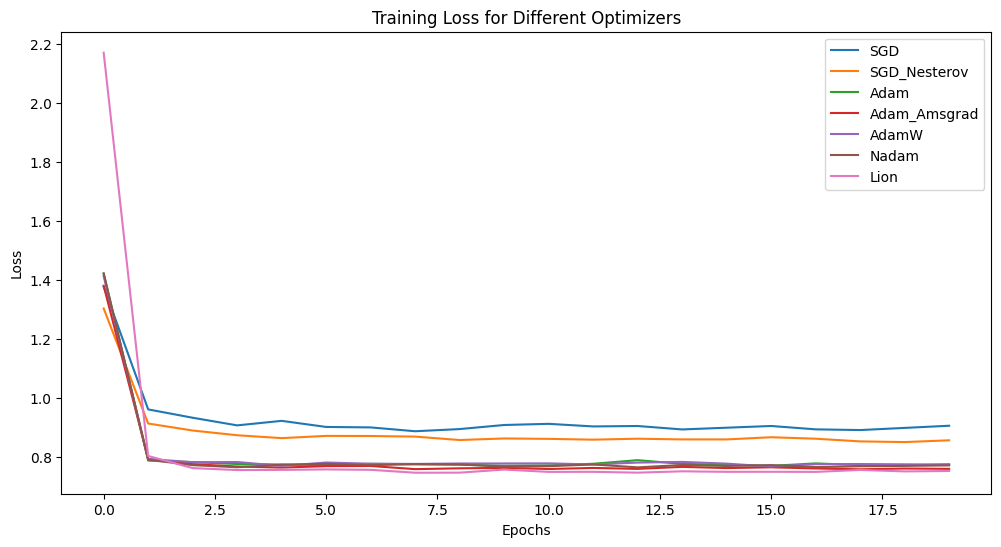

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

for name, history in histories.items():
    plt.plot(history['loss'], label=f"{name}")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss for Different Optimizers')
plt.show()

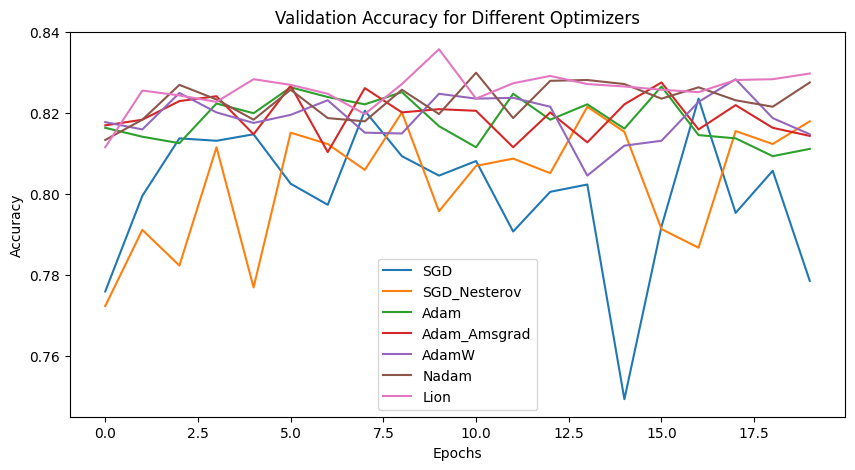

In [ ]:
plt.figure(figsize=(10, 5))
for name, history in histories.items():
    plt.plot(history['val_accuracy'], label=f"{name}")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy for Different Optimizers')
plt.show()

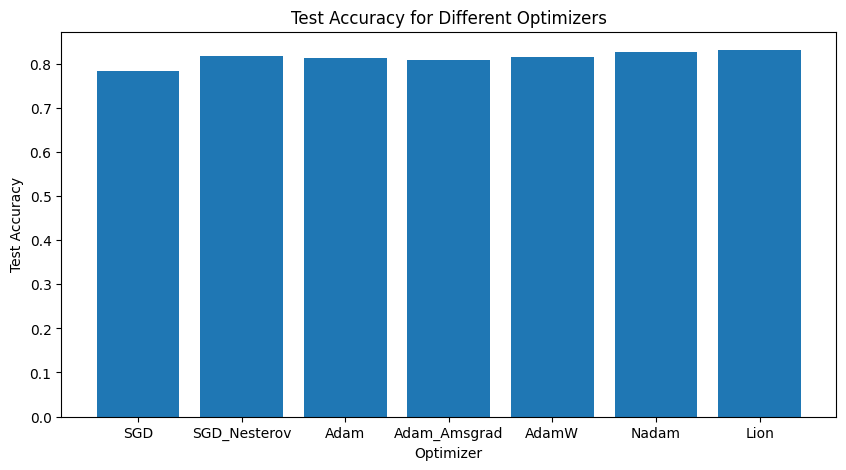

In [ ]:
plt.figure(figsize=(10, 5))

plt.bar(test_accuracies.keys(), test_accuracies.values())
plt.xlabel('Optimizer')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy for Different Optimizers')
plt.show()

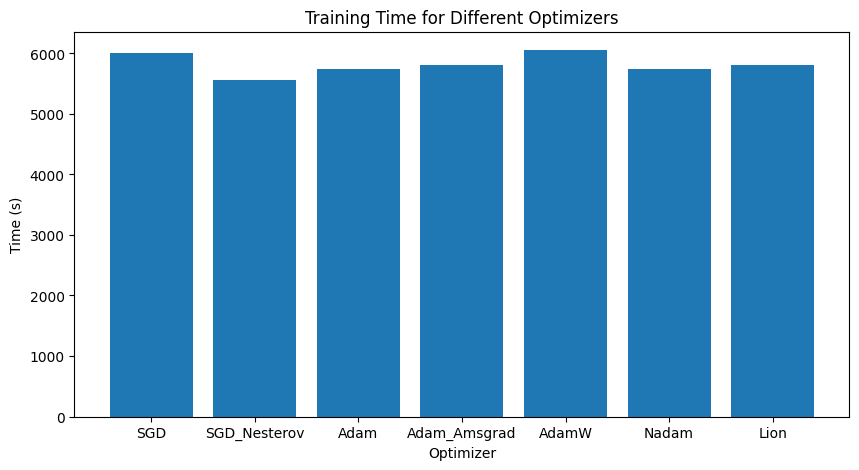

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

plt.bar(training_times.keys(), training_times.values())
plt.xlabel('Optimizer')
plt.ylabel('Time (s)')
plt.title('Training Time for Different Optimizers')
plt.show()

In [4]:
print(test_accuracies)
print(training_times)

{'SGD': 0.7824000120162964, 'SGD_Nesterov': 0.817799985408783, 'Adam': 0.8134999871253967, 'Adam_Amsgrad': 0.8087000250816345, 'AdamW': 0.8155999779701233, 'Nadam': 0.8267999887466431, 'Lion': 0.8312000036239624}
{'SGD': 6012.227033615112, 'SGD_Nesterov': 5553.617041110992, 'Adam': 5744.208878517151, 'Adam_Amsgrad': 5804.651992321014, 'AdamW': 6055.1800532341, 'Nadam': 5747.203651666641, 'Lion': 5813.766118049622}
